In [42]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 

In [43]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

## create basis & function demo

In [44]:
np.random.seed(1234567)

In [45]:

def simulate_random_dag(d: int,
                        degree: float,
                        w_range: tuple = (1.0, 1.0)) -> nx.DiGraph:
    """Simulate random DAG with an expected degree by Erdos-Renyi model.
        
        Args:
        d: number of nodes
        degree: expected node degree, in + out
        w_range: weight range +/- (low, high)
        
        Returns:
        G: weighted DAG
        """
    prob = float(degree) / (d - 1)
    B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    
    # remove all in-edges (from precedent nodes) of the first node as A
    W[:, 0] = 0
    # remove all out-edges (from descendent nodes) of the last node as Y
    W[d-1, :] = 0
    # the remained nodes are the mediators M; and reset mediators if it has higher topological order than A or lower order than Y.
    ordered_vertices = list(nx.topological_sort(nx.DiGraph(W)))
    j = 1
    while j < d - 1:
        if  ordered_vertices.index(j) < ordered_vertices.index(0):
            W[j, 1:(d - 1)] = np.zeros (d - 2)
        if  ordered_vertices.index(j) > ordered_vertices.index(d - 1):
            W[1:(d - 1), j] = np.zeros (d - 2)
        j = j + 1
    #print("True weighted adjacency matrix B:\n", W)
    G = nx.DiGraph(W)
    calculate_effect(W)
    return W

In [46]:
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
base_DAG

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


array([[ 0., -1., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0., -0.],
       [ 0.,  1., -0.,  0.,  1.],
       [ 0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [47]:
random.seed(1234567)
pick_element=random.sample(range(5), 2) ## pick two location to mutate
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]

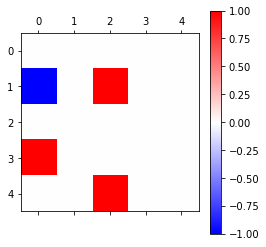

In [48]:
plt.matshow(base_DAG.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

In [11]:
import math 
def cos(x):
    return ((math.cos(x/6*math.pi))/4+1)*0.8
def quadratic(x):
    return(-5+(10-x)**2)/200+0.5

t: [0.   0.   0.   2.25 4.5  6.75 9.   9.   9.  ]
c: [1. 1. 1. 1. 1. 1. 0. 0. 0.]
k: 2



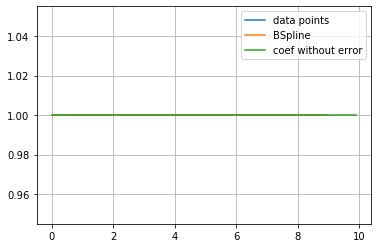

In [12]:
degree =2
time_point=10
x = np.array(range(0, time_point))
#y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x])
y = np.array([1 for i in x])
#y = np.array([1 for i in x])
z= [1 for i in np.array(range(0, time_point*10))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.plot([i/10 for i in np.array(range(0, time_point*10))], z, label='coef without error')
plt.grid()
plt.legend(loc='best')
plt.show()

t: [0.   0.   0.   2.25 4.5  6.75 9.   9.   9.  ]
c: [0.99990351 0.99634813 0.75384184 0.56636058 0.66701045 0.80050726
 0.         0.         0.        ]
k: 2



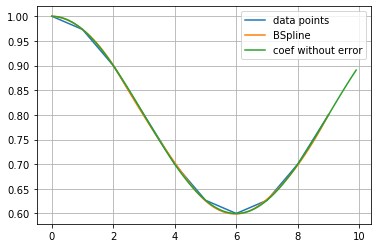

In [13]:
degree =2
time_point=10
x = np.array(range(0, time_point))
#y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x])
y = np.array([cos(i) for i in x])
#y = np.array([1 for i in x])
z= [cos(i/10) for i in np.array(range(0, time_point*10))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.plot([i/10 for i in np.array(range(0, time_point*10))], z, label='coef without error')
plt.grid()
plt.legend(loc='best')
plt.show()

t: [0.   0.   0.   2.25 4.5  6.75 9.   9.   9.  ]
c: [0.975    0.8625   0.688125 0.564375 0.49125  0.48     0.       0.
 0.      ]
k: 2



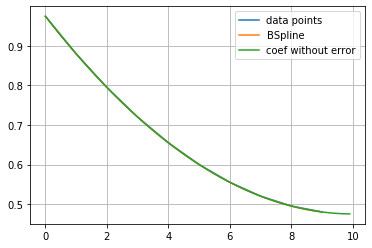

In [14]:
degree =2
time_point=10
x = np.array(range(0, time_point))
#y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x])
y = np.array([quadratic(i) for i in x])
z= [quadratic(i/10) for i in np.array(range(0, time_point*10))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.plot([i/10 for i in np.array(range(0, time_point*10))], z, label='coef without error')
plt.grid()
plt.legend(loc='best')
plt.show()

In [15]:
from scipy.interpolate import BSpline
k = 3
t = t
c1 = [1,0,0,0,0,0]
c2 = [0,1,0,0,0,0]
c3 = [0,0,1,0,0,0]
c4 = [0,0,0,1,0,0]
c5 = [0,0,0,0,1,0]
c6 = [0,0,0,0,0,1]
spl1 = BSpline(t, c1, k)
spl2 = BSpline(t, c2, k)
spl3 = BSpline(t, c3, k)
spl4 = BSpline(t, c4, k)
spl5 = BSpline(t, c5, k)
spl6 = BSpline(t, c6, k)

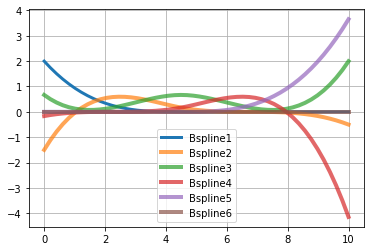

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xx = np.linspace(0, time_point, 50)
ax.plot(xx, spl1(xx), lw=3, label='Bspline1')
ax.plot(xx, spl2(xx), lw=4, alpha=0.7, label='Bspline2')
ax.plot(xx, spl3(xx), lw=4, alpha=0.7, label='Bspline3')
ax.plot(xx, spl4(xx), lw=4, alpha=0.7, label='Bspline4')
ax.plot(xx, spl5(xx), lw=4, alpha=0.7, label='Bspline5')
ax.plot(xx, spl6(xx), lw=4, alpha=0.7, label='Bspline6')
ax.grid(True)
ax.legend(loc='best')
plt.show()

## create data

In [17]:
def data_create(seed,time_stamp,set_graph):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  #y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x]) #generate coefficient
  y=np.array([cos(i) for i in x])
  z=np.array([quadratic(i) for i in x])##edited to have multiple
  base_DAG=set_graph 
  base_DAG[pick_1]=y[0]##edited to be coeffcient with error
  base_DAG[pick_2]=z[0]###multiple
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[pick_1]=y[i]##edited to be coeffcient with error
      base_DAG[pick_2]=z[i]###multiple
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
      print(base_DAG)
  return X_all

In [18]:
n = 30 # The number of samples of data.
d = 5 # The number of variables in data.
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
n_times=30
seed_list=np.random.randint(1, 1000000, size=n_times)
seed=seed_list[0]
X_all=data_create(seed,time_stamp,base_DAG) #create data

[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

In [19]:
X_all.shape #(30*10)*5

(300, 5, 1)

In [20]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random

import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed
import time

# new method

In [21]:
# ----------- Configurations:
time_stamp=10
n_timestamp=time_stamp
sample__time=30##sample per timepoint
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = n_var # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [22]:
n_timestamp

10

In [23]:
sample__time

30

In [24]:
X_all.shape

(300, 5, 1)

In [25]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time*time_stamp, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_column=np.zeros((sample__time*time_stamp, n_var,1))#for each spline
        for i in range(0,n_timestamp):
            D_column[(sample__time*i):(sample__time*(i+1)),:,:]=X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#X_i *f(i), stack horizontally
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_column
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [26]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5,spl6]

In [27]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [28]:
# ----------- Configurations:
n = 30*time_stamp # The number of samples of data.
d = 36 # The number of variables in data after spline.  (p+1*k)
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [29]:
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:,:p]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0]))+sum(sum(abs(B[p:, p:]))) # uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [30]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [31]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            #h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            h1_B =0
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:,:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [32]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [33]:
from scipy.interpolate import BSpline
def spline_create(m):
    degree =2
    x = np.array(range(0, 11))
    y = np.array([cos(i) for i in x])
    z= [cos(i/10) for i in np.array(range(0, 110))]
    step = (x[-1] - x[0]) / (m + 1)
    knots = np.linspace(step, m * step, m)

    t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

    print('''\
    t: {}
    c: {}
    k: {}
    '''.format(t, c, k))
    N = 100
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    ##get the spline
    k = 2
    t = t
    c1 = [1,0,0,0,0,0,0,0]
    c2 = [0,1,0,0,0,0,0,0]
    c3 = [0,0,1,0,0,0,0,0]
    c4 = [0,0,0,1,0,0,0,0]
    c5 = [0,0,0,0,1,0,0,0]
    c6 = [0,0,0,0,0,1,0,0]
    c7 = [0,0,0,0,0,0,1,0]
    c8 = [0,0,0,0,0,0,0,1]
    spl1 = BSpline(t, c1, k)
    spl2 = BSpline(t, c2, k)
    spl3 = BSpline(t, c3, k)
    spl4 = BSpline(t, c4, k)
    spl5 = BSpline(t, c5, k)
    spl6 = BSpline(t, c6, k)
    spl7 = BSpline(t, c7, k)
    spl8 = BSpline(t, c8, k)
    
    spline_list=[spl1,spl2,spl3,spl4,spl5,spl6,spl7,spl8]
    spline_list=spline_list[:(m+k+1)]
    return(spline_list)

In [35]:
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)

ELBO_total_new=[]
NLL_total_new=[]
MSE_total_new=[]
time_list_new=[]

ELBO_valid_new=[]
NLL_valid_new=[]
MSE_valid_new=[]

seed=seed_list[0]
X_all=data_create(seed,time_stamp,base_DAG) #create data
for knots in range(1,6): ##for number of basis
    spline_list=spline_create(knots)
    D=create_D(X_all,spline_list)
    data_all=np.append(X_all,D, axis=1)
    print(np.shape(data_all))
    lambda_list=np.zeros((5,(n_var*(knots+2+1)),n_var))
    for fold in range(5): #for folds selected
        remove_fold=list(range(fold,300+fold,5))
        data_fold=np.delete(data_all, remove_fold, axis=0) 
        print("knots=",knots,"folds=",fold)
        print(np.shape(data_fold))

          ####estimate at each time_stamp####
        timestart_new=time.time()
 # ----------- Configurations:
        p=5
        k=knots+2+1 #no.of basis
        n = 24*time_stamp # The number of samples of data.
        d = p+p*k # The number of variables in data after basis.
        x_dims = 1 # The number of input dimensions: default 1.
        z_dims = d # The number of latent variable dimensions: default the same as variable size.
        epochs = 200 # Number of epochs to train.
        batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
        k_max_iter = int(1e2) # The max iteration number for searching parameters.
        original_lr = 3e-3  # Initial learning rate.
        encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
        decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
        temp = 0.5 # Temperature for Gumbel softmax.
        factor = True # Factor graph model.
        encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
        decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
        tau_B = 0. # Coefficient for L-1 norm of matrix B.
        lambda1 = 0. # Coefficient for DAG constraint h1(B).
        lambda2 = 0. # Coefficient for identification constraint h2(B).
        c_B = 1 # Coefficient for absolute value h1(B).
        d_B = 1 # Coefficient for absolute value h2(B).
        e_B = 1 # Coefficient for absolute value h3(B)
        h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
        h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
        h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
        lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
        gamma = 1.0 # LR decay factor.  
        ######################
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        feat_train = torch.FloatTensor(data_fold)
        feat_valid = torch.FloatTensor(data_all[remove_fold])
        feat_test = torch.FloatTensor(data_fold)

        # Reconstruct itself
        train_data = TensorDataset(feat_train, feat_train)
        valid_data = TensorDataset(feat_valid, feat_valid)
        test_data = TensorDataset(feat_test, feat_train)

        train_loader = DataLoader(train_data, batch_size = batch_size)
        valid_loader = DataLoader(valid_data, batch_size = batch_size)
        test_loader = DataLoader(test_data, batch_size = batch_size)

        # ----------- Load modules:
        d1=p+p*k
        off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
        rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
        rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
        rel_rec = torch.DoubleTensor(rel_rec)
        rel_send = torch.DoubleTensor(rel_send)
        adj_A = np.zeros((d1, d1)) # Add adjacency matrix

        encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                              int(z_dims), adj_A,
                              batch_size = batch_size,
                              do_prob = encoder_dropout, factor = factor).double()
        decoder = MLPDecoder(d1 * x_dims,
                              z_dims, x_dims, encoder,
                              data_variable_size = d1,
                              batch_size = batch_size,
                              n_hid=decoder_hidden,
                              do_prob=decoder_dropout).double()

        # ----------- Set up optimizer:
        optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                      gamma = gamma)

        rel_rec = Variable(rel_rec)
        rel_send = Variable(rel_send)

        # ----------- Main:
        best_ELBO_loss = np.inf
        best_NLL_loss = np.inf
        best_MSE_loss = np.inf
        h1_B_new = 1 #torch.tensor(1.)
        h2_B_new = 1
        h1_B_old = np.inf
        h2_B_old = np.inf
        lr = original_lr

        try:
          for step_k in range(k_max_iter):
              while c_B * d_B < 1e+20:
                  for epoch in range(epochs):
                      old_lr = lr 
                      ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                      if ELBO_loss < best_ELBO_loss:
                          best_ELBO_loss = ELBO_loss

                      if NLL_loss < best_NLL_loss:
                          best_NLL_loss = NLL_loss

                      if MSE_loss < best_MSE_loss:
                          best_MSE_loss = MSE_loss

                  if ELBO_loss > 2 * best_ELBO_loss:
                      break

                  # Update parameters
                  B_new = origin_B.data.clone()
                  #h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
                  h1_B=0 
                  for i in range(n_timestamp):
                      #aa=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p),B_new[p:,:p]))#acyclity on Gamma
                      #print(aa)
                      output, identity=spl_consraint(spline_list,i,p)
                      h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:,:p].type(torch.FloatTensor))))
                      #h1_B=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),B_new[p:,:p].type(torch.FloatTensor)))#acyclity on Gamma
                  h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top
                  #B_trans_new=torch.transpose(B_new, 0, 1)
                  #h1_B = fun_h1_B(B_trans_new[p:,p:]) #acyclity on G
                  #h1_B = fun_h1_B(B_new[p:,:p]) #edited acyclity on G
                  #h2_B = fun_h3_B(B_new) ##handle the zero

                  if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      c_B *= 10
                      d_B *= 10
                  elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                      c_B *= 10
                  elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      d_B *= 10
                  else:
                      break

              # Update parameters    
              h1_B_old = h1_B_new
              h2_B_old = h2_B_new
              lambda1 += c_B * h1_B_new
              lambda2 += d_B * h2_B_new

              if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
                  break

        except KeyboardInterrupt:
          print('KeyboardInterrupt')

        predB = np.matrix(origin_B.data.clone().numpy())
        pred_gamma=predB[p:,:(p)]
        lambda_list[fold,::]=pred_gamma
        np.save(("full_10_30_gamma_basis_new"+str(knots)),lambda_list)
        
        ELBO_total_new.append(best_ELBO_loss)
        NLL_total_new.append(best_NLL_loss)
        MSE_total_new.append(best_MSE_loss)
        
        timeend_new=time.time()
        time_list_new.append(timeend_new-timestart_new)
        print(timeend_new-timestart_new)
        
        ###print valid loss
        nll_valid = []
        kl_valid = []
        mse_valid = []

        for batch_idx, (data, relations) in enumerate(valid_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll

            mse_valid.append(F.mse_loss(preds, target).item())
            nll_valid.append(loss_nll.item())
            kl_valid.append(loss_kl.item())
        ELBO_valid_new.append(mean(mse_valid))
        NLL_valid_new.append(mean(nll_valid))
        MSE_valid_new.append(mean(kl_valid))
        print("mse_valid:",mean(mse_valid),"nll_valid:",mean(nll_valid),"kl_valid:",mean(kl_valid))
            
        


[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2463.2737090587616
mse_valid: 1.239459764009594e-07 nll_valid: 1.5493247050119917e-06 kl_valid: 0.00034973085630861167
knots= 1 folds= 1
(240, 25, 1)
2193.166297197342
mse_valid: 5.376657205848891e-07 nll_valid: 6.720821507311107e-06 kl_valid: 0.0002884108131259265
knots= 1 folds= 2
(240, 25, 1)
1966.0918672084808
mse_valid: 1.9495295280957003e-05 nll_valid: 0.0002436911910119625 kl_valid: 0.00028828507347216563
knots= 1 folds= 3
(240, 25, 1)
1970.206442117691
mse_valid: 4.0896935456579003e-07 nll_valid: 5.112116932072378e-06 kl_valid: 0.0002874160694829272
knots= 1 folds= 4
(240, 25, 1)
2179.562173128128
mse_valid: 1.0233997519131087e-05 nll_valid: 0.00012792496898913848 kl_valid: 0.0002736959107881131
    t: [ 0.          0.          0.          3.33333333  6.66666667 10.
 10.         10.        ]
    c: [1.0014131  0.97520621 0.55363068 0.68795566 0.90571202 0.
 0.         0.        ]
    k: 2
    
(300, 30, 1)
knots= 2 folds= 0
(240, 30, 1)
2151.9335622787476
mse_valid: 8.040694761

In [39]:
df_new = pd.DataFrame(columns=('ELBO', 'NLL',"MSE","time"))
df_new["ELBO"]=ELBO_total_new
df_new["NLL"]=NLL_total_new
df_new["MSE"]=MSE_total_new
df_new["time"]=time_list_new
df_new
df_new.to_csv("full_new_5_basis.csv")

In [40]:
df_new.groupby(np.arange(len(df_new))//5).mean()

,ELBO,NLL,MSE,time
0,0.000300,8.455001e-07,6.764001e-08,2154.460098
1,0.000366,7.060223e-07,4.706815e-08,2201.758183
2,0.000329,1.227910e-06,7.016631e-08,2615.736651
3,0.000423,2.382649e-06,1.191325e-07,2656.447520
4,0.000336,1.396765e-06,6.207843e-08,2958.432893


In [36]:
df_new = pd.DataFrame(columns=('ELBO', 'NLL',"MSE","time"))
df_new["ELBO"]=ELBO_valid_new
df_new["NLL"]=NLL_valid_new
df_new["MSE"]=MSE_valid_new
df_new
df_new.to_csv("full_new_5_basis_valid.csv")

In [38]:
df_new.groupby(np.arange(len(df_new))//5).mean()

,ELBO,NLL,MSE
0,0.000006,0.000077,0.000298
1,0.000013,0.000190,0.000364
2,0.000001,0.000018,0.000325
3,0.000001,0.000022,0.000420
4,0.000002,0.000036,0.000332


In [33]:
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
#seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp,n_var,n_var))
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
time_list_new=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,base_DAG) #create data
  D=create_D(X_all,spline_list)
  data_all=np.append(X_all,D, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = 30*time_stamp # The number of samples of data.
  d = 36 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=6 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              #h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              h1_B=0 
              for i in range(n_timestamp):
                  #aa=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p),B_new[p:,:p]))#acyclity on Gamma
                  #print(aa)
                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:,:p].type(torch.FloatTensor))))
                  #h1_B=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),B_new[p:,:p].type(torch.FloatTensor)))#acyclity on Gamma
              h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top
              #B_trans_new=torch.transpose(B_new, 0, 1)
              #h1_B = fun_h1_B(B_trans_new[p:,p:]) #acyclity on G
              #h1_B = fun_h1_B(B_new[p:,:p]) #edited acyclity on G
              #h2_B = fun_h3_B(B_new) ##handle the zero

              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:,:(p)]
  def matrix_gen(t):
    output,identity=spl_consraint(spline_list,t,p)
    return torch.matmul(identity.type(torch.FloatTensor),torch.from_numpy((np.multiply(output.numpy(),pred_gamma))).type(torch.FloatTensor)).T
  #estimated_coefficient=[matrix_gen(i)[4,0].item() for i in range(time_stamp)]
  #average_coef_list_new[replicate,:]=estimated_coefficient

  ## FDR, TPR, SHD for  new method
  FDR_list_piece_new=[]
  TPR_list_piece_new=[]
  SHD_list_piece_new=[]
  #base_DAG=np.zeros((5, 5))
  for i in range(time_stamp):
      #base_DAG[0,4]=cos(i)
      #base_DAG[2,3]=quadratic(j)
      #base_DAG[3,4]=-1 ###constant
      #base_DAG[2,4]=-1
      #base_DAG[base_DAG<0.4]=0##change base_DAG
     #FDR, TPR, SHD
      #base_DAG[base_DAG<0.4] = 0 ##edited to remove the effect
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      average_coef_list_new[replicate,i,:,:]=matrix_gen(i).numpy()
      a=matrix_gen(i).numpy()
      a[abs(a)<0.3] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)
    
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
  np.save("full_20_30",average_coef_list_new)
  FDR_total_new.append(mean(FDR_list_piece_new))
  TPR_total_new.append(mean(TPR_list_piece_new))
  SHD_total_new.append(mean(SHD_list_piece_new))
  timeend_new=time.time()
  time_list_new.append(timeend_new-timestart_new)
  ###write csv
  df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df_new["FDR"]=FDR_total_new
  df_new["TPR"]=TPR_total_new
  df_new["SHD"]=SHD_total_new
  df_new["time"]=time_list_new
  #df_new.to_csv("cos_new_5.csv")
  print(replicate)


[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0004776863893154498
Best NLL Loss : 7.005861711653826e-07
Best MSE Loss : 4.003349549516473e-08
0
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.  

Best ELBO Loss : 0.0004705567344725719
Best NLL Loss : 9.117112515301907e-07
Best MSE Loss : 5.2097785801725164e-08
4
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1. 

Best ELBO Loss : 0.00045349797897385584
Best NLL Loss : 2.2263643431775164e-06
Best MSE Loss : 1.272208196101438e-07
8
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.

Best ELBO Loss : 0.0007178084396707768
Best NLL Loss : 2.8424286998659217e-05
Best MSE Loss : 1.6242449713519556e-06
12
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1

Best ELBO Loss : 0.0007470046888813739
Best NLL Loss : 2.400400593038276e-05
Best MSE Loss : 1.3716574817361578e-06
16
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.

Best ELBO Loss : 0.0005697077075571787
Best NLL Loss : 5.260044159555958e-06
Best MSE Loss : 3.0057395197462616e-07
20
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.

Best ELBO Loss : 0.0005676777683500656
Best NLL Loss : 3.2273471420171475e-06
Best MSE Loss : 1.8441983668669413e-07
24
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1

Best ELBO Loss : 0.0005162463817446125
Best NLL Loss : 1.56559297583284e-06
Best MSE Loss : 8.946245576187656e-08
28
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.  

In [39]:
seed_list

array([913812, 374400, 343669, 289095, 235846, 432099, 448097, 384097,
       134030, 454991, 401627,  97188, 615884, 585262, 902641, 897795,
       678150, 361884, 928159, 446640,  26580, 865407, 789523, 704840,
       359269,  38248, 809111, 137636, 698530, 230177])

In [40]:
average_coef_list_new.shape

(30, 10, 5, 5)

In [94]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [34]:
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
df_new["time"]=time_list_new

df_new

,FDR,TPR,SHD,time
0,0.050000,0.700,1.4,3258.330431
1,0.020000,0.825,0.8,3326.005435
2,0.000000,0.775,0.9,3513.402346
3,0.000000,0.650,1.4,4169.488957
4,0.158333,0.525,2.4,3877.003762
5,0.125000,0.475,2.5,3563.864658
6,0.000000,0.675,1.3,3894.198721
7,0.116667,0.450,2.5,4116.859723
8,0.000000,0.800,0.8,3770.608342
9,0.000000,0.425,2.3,3720.932009


In [61]:
result_new=np.load("result/full_20_30.npy") #0 axis is the number of replicates
result_ANOCA=np.load("result/full_20_30_ANOCA.npy")
result_NOTEARS=np.load("result/full_10_30_NOTEARS.npy")
result_dynotears=np.load("result/dynotears_full_w_noA.npy")
result_DAGGNN=np.load("result/S2_10_30_DAGGNN.npy")

In [49]:
#proposed
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
random.seed(1234567)
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    for i in range(time_stamp):
        base_DAG[pick_1]=cos(i)##edited to be coeffcient with error
        base_DAG[pick_2]=quadratic(i)###multiple
        base_DAG[abs(base_DAG)<0.2] = 0
        base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        a=result_new[replicate,i,:,:]
        a[abs(a)<0.2] = 0
        base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

        FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
        FDR_list_piece_new.append(FDR)
        TPR_list_piece_new.append(TPR)
        SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


FDR    0.119389
TPR    0.850833
SHD    1.120000
dtype: float64

In [50]:
df_new.std()/np.sqrt(30)

FDR    0.010758
TPR    0.021425
SHD    0.106501
dtype: float64

In [64]:
#DAGGNN
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
random.seed(1234567)
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    for i in range(time_stamp):
        base_DAG[pick_1]=cos(i)##edited to be coeffcient with error
        base_DAG[pick_2]=quadratic(i)###multiple
        base_DAG[abs(base_DAG)<0.2] = 0
        base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        a=result_DAGGNN[replicate,i,:,:]
        a[abs(a)<0.2] = 0
        base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

        FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
        FDR_list_piece_new.append(FDR)
        TPR_list_piece_new.append(TPR)
        SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


FDR    0.616124
TPR    0.483333
SHD    5.100000
dtype: float64

In [65]:
df.std()/np.sqrt(30)

FDR    0.021153
TPR    0.033513
SHD    0.165045
dtype: float64

In [66]:
#ANOCA
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
random.seed(1234567)
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(30):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[pick_1]=cos(i)##edited to be coeffcient with error
      base_DAG[pick_2]=quadratic(i)###multiple
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_ANOCA[replicate,i,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


FDR    0.358009
TPR    0.835833
SHD    2.826667
dtype: float64

In [67]:
df.std()/np.sqrt(30)

FDR    0.021153
TPR    0.033513
SHD    0.165045
dtype: float64

In [68]:
#NOTEARS
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
random.seed(1234567)
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    for i in range(time_stamp):
        base_DAG[pick_1]=cos(i)##edited to be coeffcient with error
        base_DAG[pick_2]=quadratic(i)###multiple
        base_DAG[abs(base_DAG)<0.2] = 0
        base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        a=result_NOTEARS[replicate,i,:,:]
        a[abs(a)<0.2] = 0
        base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

        FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
        FDR_list_piece_new.append(FDR)
        TPR_list_piece_new.append(TPR)
        SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


FDR    0.501111
TPR    0.251667
SHD    3.026667
dtype: float64

In [69]:
df.std()/np.sqrt(30)

FDR    0.021153
TPR    0.033513
SHD    0.165045
dtype: float64

In [70]:
#DYNOTEARS
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
random.seed(1234567)
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    for i in range(time_stamp-1):
        base_DAG[pick_1]=cos(i+1)##edited to be coeffcient with error
        base_DAG[pick_2]=quadratic(i+1)###multiple
        base_DAG[abs(base_DAG)<0.2] = 0
        base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        a=result_dynotears[replicate,i,:,:]
        a[abs(a)<0.2] = 0
        base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

        FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
        FDR_list_piece_new.append(FDR)
        TPR_list_piece_new.append(TPR)
        SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


FDR    0.502469
TPR    0.250000
SHD    3.029630
dtype: float64

In [71]:
df_new.std()/np.sqrt(30)

FDR    0.001169
TPR    0.000000
SHD    0.009124
dtype: float64

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]
The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]
The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]
The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


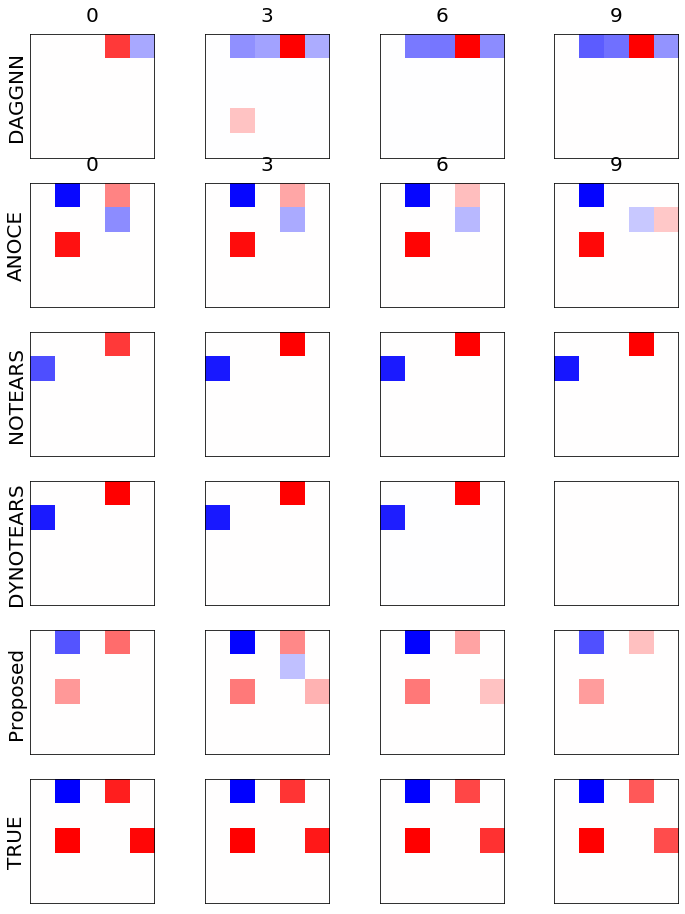

In [72]:
select_time=[0,3,6,9]
methods=["DAGGNN","ANOCE","NOTEARS","DYNOTEARS","Proposed","TRUE"]
figure, axs = plt.subplots(nrows=len(methods), ncols=4, figsize=(12, 16))
for i in range(len(select_time)):
    actual_time=select_time[i]
    #DAGGNN
    DAGGNN_graph=result_DAGGNN[:,actual_time,:,:].mean(axis=0).T
    DAGGNN_graph[abs(DAGGNN_graph)<0.2]=0
    axs[0, i].matshow(DAGGNN_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    axs[0, i].set_title(str((select_time[i])),fontdict={'fontsize': 20})
    ##ANOCA
    ANOCA_graph=result_ANOCA[:,actual_time,:,:].mean(axis=0)
    ANOCA_graph[abs(ANOCA_graph)<0.2]=0
    axs[1, i].matshow(ANOCA_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    axs[1, i].set_title(str((select_time[i])),fontdict={'fontsize': 20})
    ##NOTEARS plot
    NOTEARS_graph=result_NOTEARS[:,actual_time,:,:].mean(axis=0).T
    NOTEARS_graph[abs(NOTEARS_graph)<0.2]=0
    axs[2, i].matshow(NOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##DYNOTEARS plot
    DYNOTEARS_graph=result_dynotears[:,actual_time,:,:].mean(axis=0).T
    DYNOTEARS_graph[abs(DYNOTEARS_graph)<0.2]=0
    axs[3, i].matshow(DYNOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##proposed plot-nolag
    proposed_graph=result_new[:,actual_time,:,:].mean(axis=0).T
    proposed_graph[abs(proposed_graph)<0.2]=0
    axs[4, i].matshow(proposed_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##True plot
    np.random.seed(123456)
    base_DAG=simulate_random_dag(5,4)
    base_DAG[pick_1]=cos(i+1)##edited to be coeffcient with error
    base_DAG[pick_2]=quadratic(i+1)###multiple
    base_DAG[abs(base_DAG)<0.2] = 0
    axs[5, i].matshow(base_DAG, cmap = 'bwr', vmin = -1, vmax = 1)
for j in range(len(methods)):
    axs[j, 0].set(ylabel=methods[j])
    axs[j, 0].yaxis.label.set_size(20)
for i in range(len(methods)):
    for j in range(4):
        axs[i][j].get_xaxis().set_ticks([])
        axs[i][j].get_yaxis().set_ticks([])
plt.savefig("S2_nolag_graph.pdf")


In [73]:
MSE_list_proposed=[]
MSE_list_dynotears=[]
MSE_list_ANOCA=[]
MSE_list_NOTEARS=[]
MSE_list_DAGGNN=[]
for j in range(30):
    MSE_list_dynotears.append(mean((result_dynotears[j,:,3,0]-[quadratic(i) for i in range(10)])**2))
    MSE_list_proposed.append(mean((result_new[j,:,3,0]-[quadratic(i) for i in range(10)])**2))
    MSE_list_ANOCA.append(mean((result_ANOCA[j,:,0,3]-[quadratic(i) for i in range(10)])**2))
    MSE_list_DAGGNN.append(mean((result_DAGGNN[j,:,3,0]-[quadratic(i) for i in range(10)])**2))
    MSE_list_NOTEARS.append(mean((result_NOTEARS[j,:,3,0]-[quadratic(i) for i in range(10)])**2))

In [74]:
import statistics
print("dynotears",round(mean(MSE_list_dynotears),2), round(statistics.pstdev(MSE_list_dynotears)/math.sqrt(30),3))
print("proposed",round(mean(MSE_list_proposed),2), round(statistics.pstdev(MSE_list_proposed)/math.sqrt(30),3))
print("ANOCA",round(mean(MSE_list_ANOCA),2), round(statistics.pstdev(MSE_list_ANOCA)/math.sqrt(30),3))
print("NOTEARS",round(mean(MSE_list_NOTEARS),2), round(statistics.pstdev(MSE_list_NOTEARS)/math.sqrt(30),3))
print("DAGGNN",round(mean(MSE_list_DAGGNN),2), round(statistics.pstdev(MSE_list_DAGGNN)/math.sqrt(30),3))

dynotears 0.5 0.004
proposed 0.08 0.005
ANOCA 0.15 0.013
NOTEARS 0.52 0.006
DAGGNN 0.84 0.028
